# Subcorpus selection — keyword groups, BM25, and active learning

A focused walkthrough of three complementary selection strategies:

| Method | What it does | Good for |
|---|---|---|
| **BM25** (flat) | Ranks texts by how often seed terms appear, normalised for document length | Quick first pass; treats all terms equally |
| **Keyword groups** | Scores each semantic category (location, event type, …) separately; geometric mean requires evidence in every group | Filtering out texts that only mention one aspect of the event |
| **Active learning** | Trains a classifier on your labels; uncertainty sampling finds informative examples fast | Refining and reranking after the keyword pass |

## Contents

1. Setup
2. BM25 flat scoring
3. Keyword groups
4. Active learning
5. Three-way comparison and export

## 1 — Setup

In [34]:
from narrative_subcorpora import (
    Corpus, Event, ActiveLearner,
    score_distribution, group_score_distribution,
)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 120

CORPUS_PATH = "/home/adapt/Documents/adapt/data/delpher/data/news.parquet"
EVENTS_PATH = "events.json"
TEXT_COL    = "ocr"
DATE_COL    = "date"

corpus = Corpus(CORPUS_PATH, text_col=TEXT_COL, date_col=DATE_COL)
print("Corpus loaded")
info = corpus.describe()
print(f"  {info['num_rows']:,} rows, {info['num_columns']} columns")

Corpus loaded
  27,774,347 rows, 9 columns


In [35]:
# Choose an event — change this label to work with a different event
EVENT_LABEL = "watersnood"
WINDOW_MONTHS = 6

event = Event.from_json(EVENTS_PATH, EVENT_LABEL)
print(event)
print()
for group, terms in event.term_groups.items():
    print(f"  {group:<15}: {', '.join(terms[:7])}{' ...' if len(terms) > 7 else ''}")

Watersnoodramp 1953 (1953-02-01, 66 terms, 4 groups)

  location       : zeeland, walcheren, schouwen, duiveland, tholen, beveland, goeree ...
  event_type     : watersnood, watersnoodramp, waterramp, overstroming, overstrooming, inundatie, dijkdoorbraak ...
  cause          : springtij, springvloed, springgetij, noordwesterstorm, opstuwing, watermassa, watergeweld ...
  impact         : slachtoffers, doden, verdronken, vermisten, dakloos, evacuatie, redding ...


In [36]:
# Load the time window once; all methods work on the same slice
window = corpus.after(event, months=WINDOW_MONTHS)
print(f"Time window ({WINDOW_MONTHS} months after {event.start_date}): {len(window):,} articles")

Time window (6 months after 1953-02-01): 111,317 articles


In [4]:
# Score the window with BM25 (k1=1.5 and b=0.75 are the standard defaults)
scored_bm25 = (
    corpus
    .after(event, months=WINDOW_MONTHS)
    .score_bm25(terms=event.terms, k1=1.5, b=0.75)
)

df_bm25 = scored_bm25.to_dataframe()
print("BM25 score distribution:")
print(df_bm25["score_bm25"].describe().round(3))
print(f"\nNon-zero: {(df_bm25['score_bm25'] > 0).sum():,} / {len(df_bm25):,} articles")

BM25 score distribution:
count    111317.000
mean          0.764
std           2.841
min           0.000
25%           0.000
50%           0.000
75%           0.000
max          53.173
Name: score_bm25, dtype: float64

Non-zero: 11,710 / 111,317 articles


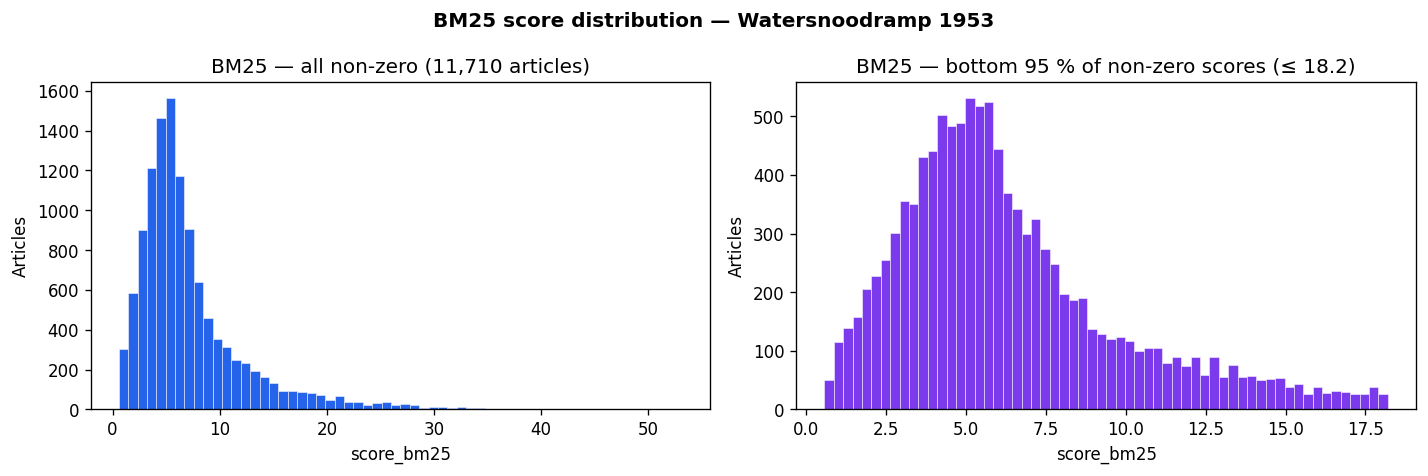

In [5]:
# Look at the distribution — BM25 scores are unbounded, so check the tail
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# All non-zero scores
nz = df_bm25.loc[df_bm25["score_bm25"] > 0, "score_bm25"]
axes[0].hist(nz, bins=60, color="#2563eb", edgecolor="white", linewidth=0.3)
axes[0].set_title(f"BM25 — all non-zero ({len(nz):,} articles)")
axes[0].set_xlabel("score_bm25")
axes[0].set_ylabel("Articles")

# Top 5 % for detail
p95 = nz.quantile(0.95)
top = nz[nz <= p95]
axes[1].hist(top, bins=60, color="#7c3aed", edgecolor="white", linewidth=0.3)
axes[1].set_title(f"BM25 — bottom 95 % of non-zero scores (≤ {p95:.1f})")
axes[1].set_xlabel("score_bm25")
axes[1].set_ylabel("Articles")

fig.suptitle(f"BM25 score distribution — {event.full_name}", fontweight="bold")
plt.tight_layout()
plt.show()

In [6]:
# Pick a threshold by inspecting percentiles of the non-zero scores
for pct in [50, 75, 90, 95, 99]:
    val = nz.quantile(pct / 100)
    n   = (df_bm25["score_bm25"] >= val).sum()
    print(f"  p{pct:>2}  threshold={val:>7.2f}  → {n:>6,} articles")

  p50  threshold=   5.73  →  5,855 articles
  p75  threshold=   8.53  →  2,928 articles
  p90  threshold=  13.71  →  1,171 articles
  p95  threshold=  18.21  →    586 articles
  p99  threshold=  28.15  →    118 articles


In [7]:
# Apply a threshold (adjust BM25_THRESHOLD based on the percentile table above)
BM25_THRESHOLD = 12

filtered_bm25 = scored_bm25.above(BM25_THRESHOLD, col="score_bm25")
print(f"BM25 >= {BM25_THRESHOLD}: {len(filtered_bm25):,} articles")

# Preview the top 5
top5_bm25 = (
    df_bm25
    .nlargest(5, "score_bm25")
    [[DATE_COL, "score_bm25"]]
)
display(top5_bm25.round(2))

# Read the best article
best = df_bm25.nlargest(1, "score_bm25").iloc[0]
print(f"\nTop BM25 article  date={best[DATE_COL]}  score={best['score_bm25']:.2f}")
print(str(best[TEXT_COL])[:600])

BM25 >= 12: 1,586 articles


/tmp/ipykernel_1504/1841346965.py:13: UserWarning: obj.round has no effect with datetime, timedelta, or period dtypes. Use obj.dt.round(...) instead.
  display(top5_bm25.round(2))


,date,score_bm25
46172,1953-02-07,53.17
71434,1953-02-24,51.91
78092,1953-04-23,49.83
80442,1953-02-06,49.17
60623,1953-02-07,49.04



Top BM25 article  date=1953-02-07 00:00:00  score=53.17
1372 doden Het totaal aantal genoteerde slachtoffers bedraagt thans 1372. Uit de ons thans ter beschikking staande gegevens blijkt, dat de meeste slachtoffers gevallen zijn op het eiland Goeree én Overflakkee n.l. 433. Over de andere eilanden en gebieden zijnde cijfers als volgt : Tholen 304, Brabant 187, Hoeksehewaard 144, Schouweji-Duive'and 115. Noord-Beveland 41, Voorne-Putten 27, Zuid-Beveland 26, Zuid-Holland 18, O. Zeeuvvsch-Vlaanderen 12, IJselmonde 10, St. Philipsland 9, Noord-Hdlland 6, Walcheren 5, Alblasserwaard 4, Land van Heusden en Altena 3, Tien Gemeenten 2, Beierland 2, aanges


---

## 3 — Keyword groups

BM25 treats all seed terms alike. An article that only mentions *Zeeland* ten times scores the same as one that mentions both *Zeeland* and *overstroming*. Grouped scoring fixes this by scoring each semantic category independently.

With the default **geometric mean**, an article must have non-zero evidence in **every** group to receive a non-zero combined score. This is strict but precise.

In [8]:
# Grouped scoring — geometric mean across all groups
scored_grouped = (
    corpus
    .after(event, months=WINDOW_MONTHS)
    .score_grouped(event.term_groups)   # adds score_{group} + score_grouped
)

df_g = scored_grouped.to_dataframe()
group_cols = [f"score_{g}" for g in event.term_groups]

print(f"{'Column':<22} {'Non-zero':>9} {'Mean':>8} {'Max':>8}")
print("-" * 52)
for col in group_cols + ["score_grouped"]:
    nz  = (df_g[col] > 0).sum()
    print(f"{col:<22} {nz:>9,} {df_g[col].mean():>8.5f} {df_g[col].max():>8.4f}")

Column                  Non-zero     Mean      Max
----------------------------------------------------
score_location             8,240  0.00730   0.8125
score_event_type           9,078  0.00862   0.5455
score_cause                  730  0.00091   0.5000
score_impact               7,054  0.00768   0.6000
score_grouped                 80  0.00010   0.3213


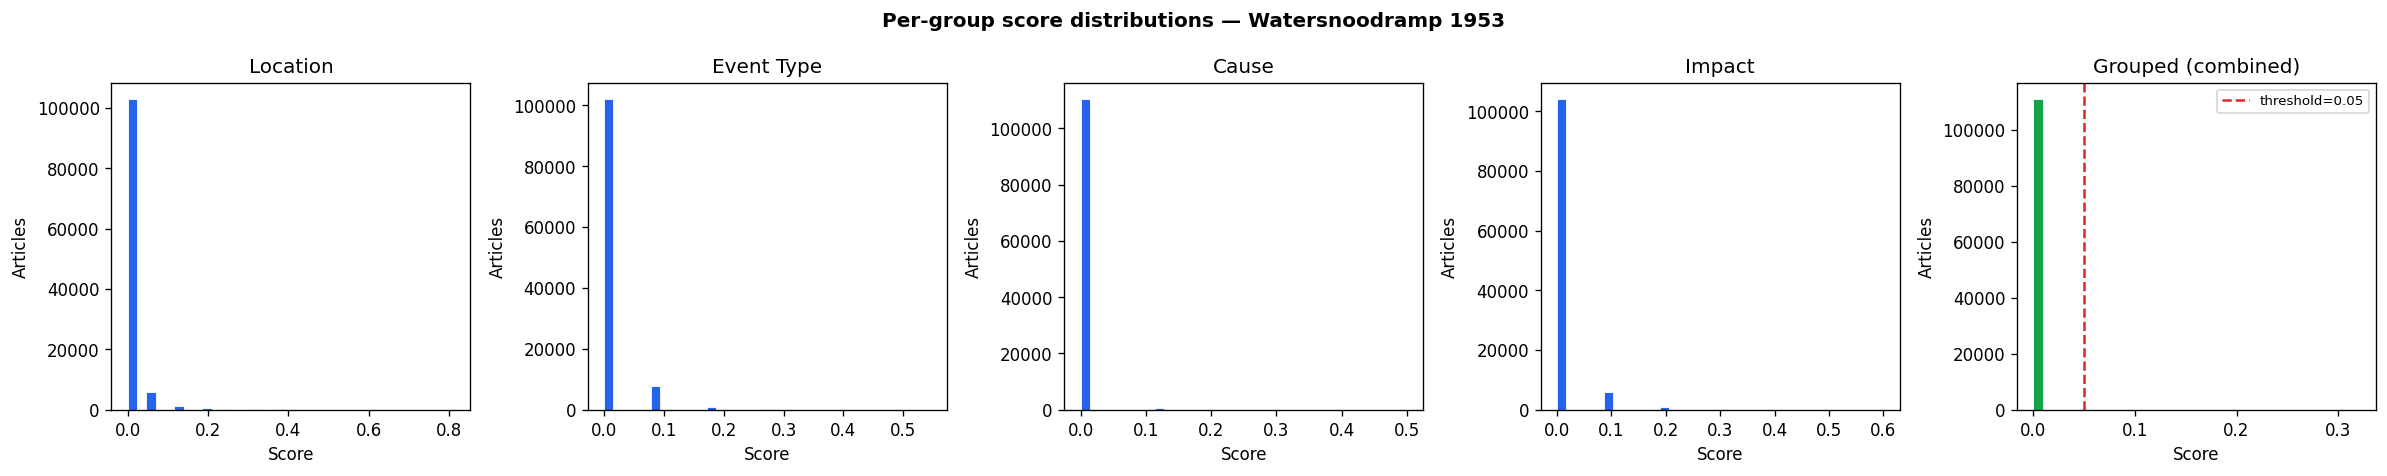

In [9]:
# Per-group score histograms
fig = group_score_distribution(
    scored_grouped,
    group_cols=group_cols,
    combined_col="score_grouped",
    threshold=0.05,
    bins=35,
)
fig.suptitle(f"Per-group score distributions — {event.full_name}", fontweight="bold")
plt.show()

In [10]:
# Which group is the bottleneck?
# An article with grouped=0 has at least one zero-scoring group.
all_hit   = df_g[df_g["score_grouped"] > 0]
geo_zero  = df_g[df_g["score_grouped"] == 0]

print(f"Articles with non-zero grouped score (all groups hit): {len(all_hit):,}")
print(f"Articles with grouped=0 (missing at least one group): {len(geo_zero):,}")
print()

# For each group, count how many articles in geo_zero score zero there
print("Bottleneck breakdown (articles where grouped=0 AND this group=0):")
for col in group_cols:
    n = (geo_zero[col] == 0).sum()
    print(f"  {col:<22}: {n:>6,} articles have no {col.replace('score_', '')} terms")

Articles with non-zero grouped score (all groups hit): 80
Articles with grouped=0 (missing at least one group): 111,237

Bottleneck breakdown (articles where grouped=0 AND this group=0):
  score_location        : 103,077 articles have no location terms
  score_event_type      : 102,239 articles have no event_type terms
  score_cause           : 110,587 articles have no cause terms
  score_impact          : 104,263 articles have no impact terms


In [11]:
# If the geometric mean is too strict, try weighted_sum — it allows partial matches
scored_ws = (
    corpus
    .after(event, months=WINDOW_MONTHS)
    .score_grouped(event.term_groups, combine="weighted_sum", col="score_ws")
)

df_ws = scored_ws.to_dataframe()
print("weighted_sum — non-zero:", (df_ws["score_ws"] > 0).sum(), "articles")
print("geometric    — non-zero:", len(all_hit), "articles")
print()
print("Choose geometric when you want ALL groups covered.")
print("Choose weighted_sum when you want to allow partial matches.")

weighted_sum — non-zero: 19875 articles
geometric    — non-zero: 80 articles

Choose geometric when you want ALL groups covered.
Choose weighted_sum when you want to allow partial matches.


In [ ]:
# Top-scoring articles by grouped score
top_grouped = (
    df_g
    .nlargest(10, "score_grouped")
    [[DATE_COL] + group_cols + ["score_grouped"]]
)
display(top_grouped.round(3))

# Read the best article
best_g = df_g.nlargest(1, "score_grouped").iloc[0]
print(f"\nTop grouped article  date={best_g[DATE_COL]}  score_grouped={best_g['score_grouped']:.4f}")
print(str(best_g[TEXT_COL])[:600])

In [ ]:
# You can also gate on individual groups directly
gated = (
    corpus
    .after(event, months=WINDOW_MONTHS)
    .score_grouped(event.term_groups)
    .above(0.0, col="score_location")    # must mention at least one location term
    .above(0.0, col="score_event_type")  # must mention at least one event-type term
)
print(f"After gating on location AND event_type: {len(gated):,} articles")
print("(Gating on just 2 groups is more lenient than requiring all 4 groups via geometric mean)")

---

## 4 — Active learning

Keyword scoring can only capture what the seed list anticipates. Active learning goes further: you label a small sample of documents, and a classifier learns to rank the rest by how likely they are to be relevant — discovering signal beyond the seed terms.

**How it works:**
1. Cold start — shows a mix of top-scored + random documents
2. You label each as *relevant* or *not relevant*
3. Classifier is retrained on those labels
4. Next round shows the documents the model is **most uncertain** about — the fastest path to improving it
5. After enough labels, export the full corpus ranked by classifier probability

In [15]:
# Build the candidate pool with both BM25 and grouped scores
# Both score columns become features for the classifier
candidate_pool = (
    corpus
    .after(event, months=WINDOW_MONTHS)
    .score_bm25(terms=event.terms)
    .score_grouped(event.term_groups)
    .above(5,col='score_bm25')
)

df_pool = candidate_pool.to_dataframe()
score_cols = [c for c in df_pool.columns if c.startswith("score")]
print(f"Candidate pool: {len(candidate_pool):,} articles")
print("Feature columns for active learner:", score_cols)

Candidate pool: 7,164 articles
Feature columns for active learner: ['score_bm25', 'score_location', 'score_event_type', 'score_cause', 'score_impact', 'score_grouped']


In [16]:
# Create the learner — features='scores' uses the score columns computed above
al = ActiveLearner(candidate_pool, features="scores", random_state=42)
print(al)

ActiveLearner(7164 docs, features='scores', untrained, labels=0 (+0/-0))


In [17]:
# Cold-start batch: inspect the first candidates before labelling
cold_batch = al.next_batch(n=10)

print(f"{'idx':>6}  {'bm25':>7}  {'grouped':>8}  {'preview'}")
print("-" * 90)
for idx in cold_batch:
    row     = df_pool.iloc[idx]
    preview = str(row[TEXT_COL])[:80].replace("\n", " ")
    print(f"{idx:>6}  {row['score_bm25']:>7.2f}  {row['score_grouped']:>8.4f}  {preview!r}")

   idx     bm25   grouped  preview
------------------------------------------------------------------------------------------
  4052    28.47    0.3213  'Ruim vierhonderd doden, vele vermisten, enorme schade Nederland is dit weekeinde'
  4773    48.86    0.2754  'Naamloze verschrikking in geheel Zeeland Ten minste dertien mensen in •het water'
  1070    31.54    0.2674  'Verdronken eiland Boven het verdronken land van Roozcnhurg uit steken de daken v'
  6194     5.92    0.2378  '„Heldenmoed, Barmhartigheid, Zelfopoffering” JOURNAAL der NAAMLOZEN van de Eendr'
  4771    22.56    0.2249  'ALVERWOESTENDE OVERSTROMING Watersnood ‘ erger dan ooit in onze geschiedenis Tot'
  3569    21.07    0.2112  'Overal waar leed is, is zegen nabij „Wij staan vol ontzag tegenover het " J C7 l'
  5226     7.76    0.0000  'Verblijf sverbod op Putten Overstroomd gebied Nieuwsdienst Algemeen Dagblad HEEN'
   850     6.39    0.0000  'Hevige rukwind Nauwelijks 2 a 300 meter had de loodsboot zich verwijderd, of

### 4.1 — Interactive annotation (recommended)

Uncomment the cell below to run the interactive labelling interface. In Jupyter it shows clickable buttons; in a terminal it falls back to text prompts.

After a few rounds of `annotate()` + automatic retraining, call `al.status()` to check model quality, then `al.to_subcorpus()` to export.

In [20]:
# Interactive annotation — uncomment to run
al.annotate(n=15)   # round 1
al.annotate(n=15)   # round 2 (uncertainty sampling)
al.status()

[ActiveLearner] Labelling 15 documents.
Enter: y = relevant, n = not relevant, s = skip, q = quit

── Document 1/15  (row 2244) ──
Kruiningerpolder uit zijn isolement Stout plan van spoorwegopzichter gelukt
GOEDERENTREINEN BIJ EB DOOR KRUININGERPOLDER Spoorbaan bij vloed anderhalve
meter i onder water (Van onze correspondent) KRUININGEN, 11 Juni — In het
zwaar geteisterde Kruiningen staat een „stationschef" in lieslaarzen. Met een
rode en groene vlag beveiligt deze optimist het eindstation op het meest
unieke baanvak ter were …


── Document 2/15  (row 2589) ──
Machtige reddingsorganisatie dag en nacht in de weer 2000 vaartuigen en
tientallen vliegtuigen doen hoop herleven Schade geschat op honderden
millioenen Terwjjl het aantal slachtoffers van de springvloed nog voortdurend
steeg, is gisteren het reddingswerk in het gehele geteisterde gebied pas goed
op volle gang gekomen. Een vloot van vaartuigen doorkruist de wateren om de
geïsoleerde bevolkingscent …


── Document 3/15  (row 3511

In [21]:
al.annotate(n=50)

[ActiveLearner] Labelling 50 documents.
Enter: y = relevant, n = not relevant, s = skip, q = quit

── Document 1/50  (row 24) ──
Reddingsploeg in zee gesleurd 4 Doden op Texel (Van onze speciale
verslaggever) DEN HELDER. 1 Febr. — Het grote, langgerekte Noordzee, eiland
Texel met lijn op vele plekken zeer kwetsbare kustlijn is er nog betrekkelijk
goed afgekomen. Wel Is de ..Eendracht" (250 bunder land en twee boerderijen)
een der vele zeepolders aan de Oostkust onder water gelopen doordat er een gat
in de zeedijk, sloeg en  …


── Document 2/50  (row 2723) ──
NOTA AAN DE TWEEDE KAMER OVER DE WATERSNOOD GEVOLGEN VAN DE RAMP VAN INVLOED
OP ONS GEHELE ECONOMISCHE LEVEN


── Document 3/50  (row 5063) ──
SCHEEPSBE WEGINGEN Aagtekerk p 16 Kreta n Pt Said Aalsdyk 17 te Rotterdam v
Antwerpen Aalsum 16 140 M W v Lissabon Abbedyk 14 v B’ttan) » New York z
Admiralengracht p 16 Vlissingen n Abo Afiena 17 v Amsterdam n Esbjerg Agatha
16 v Penang n Pladju Aktjo 14 te Kristiansund Aibert D 14 te Elin

### 4.2 — Simulated labelling

For reproducible demos or testing, we use `label_batch()` with labels derived from the grouped score (a rough proxy for ground truth).

In [22]:
def simulate_labels(al, n, threshold=0):
    """Label the next n documents using grouped score as proxy for relevance."""
    batch  = al.next_batch(n=n)
    labels = {idx: bool(df_pool.at[idx, "score_grouped"] > threshold) for idx in batch}
    al.label_batch(labels)
    n_pos = sum(v for v in labels.values())
    print(f"  labelled {len(labels)} docs  (+{n_pos} relevant / -{len(labels)-n_pos} irrelevant)")
    return labels

print("Round 1 (cold start):")
simulate_labels(al, n=15)

try:
    al.retrain()
    print("  → retrained")
except RuntimeError as e:
    print(f"  → {e}")

al.status()

Round 1 (cold start):
  labelled 15 docs  (+0 relevant / -15 irrelevant)
  → retrained
Labelled: 125 / 7164  (+101 relevant, -24 irrelevant)
Rank stability (Spearman vs previous fit): 0.930
CV F1 (k=3): 0.565 ± 0.312


In [23]:
print("Round 2 (uncertainty sampling):")
simulate_labels(al, n=15)
al.retrain()
print("  → retrained")
al.status()

Round 2 (uncertainty sampling):
  labelled 15 docs  (+0 relevant / -15 irrelevant)
  → retrained
Labelled: 140 / 7164  (+101 relevant, -39 irrelevant)
Rank stability (Spearman vs previous fit): 0.802
CV F1 (k=3): 0.530 ± 0.260


In [24]:
print("Round 3:")
simulate_labels(al, n=15)
al.retrain()
print("  → retrained")
print()
al.status()

Round 3:
  labelled 15 docs  (+0 relevant / -15 irrelevant)
  → retrained

Labelled: 155 / 7164  (+101 relevant, -54 irrelevant)
Rank stability (Spearman vs previous fit): 0.845
CV F1 (k=3): 0.505 ± 0.264


In [25]:
# Export the full pool ranked by classifier probability
al_sub = al.to_subcorpus()
df_al  = al_sub.to_dataframe()

print("score_al statistics:")
print(df_al["score_al"].describe().round(4))
print()

# Top 10 by active-learning score
top_al = (
    df_al
    .nlargest(10, "score_al")
    [[DATE_COL, "score_bm25", "score_grouped", "score_al"]]
)
display(top_al.round(3))

score_al statistics:
count    7164.0000
mean        0.3716
std         0.1549
min         0.2165
25%         0.2599
50%         0.2802
75%         0.4476
max         0.9998
Name: score_al, dtype: float64



/tmp/ipykernel_1504/1104771993.py:15: UserWarning: obj.round has no effect with datetime, timedelta, or period dtypes. Use obj.dt.round(...) instead.
  display(top_al.round(3))


,date,score_bm25,score_grouped,score_al
4052,1953-02-02,28.474,0.321,1.000
4771,1953-02-02,22.564,0.225,0.999
5884,1953-02-02,20.673,0.181,0.999
4773,1953-02-02,48.855,0.275,0.999
6194,1953-02-14,5.922,0.238,0.998
4993,1953-02-11,21.139,0.203,0.998
1070,1953-02-02,31.536,0.267,0.998
3569,1953-02-09,21.073,0.211,0.993
3664,1953-02-17,30.181,0.171,0.990
4190,1953-02-06,9.883,0.171,0.988


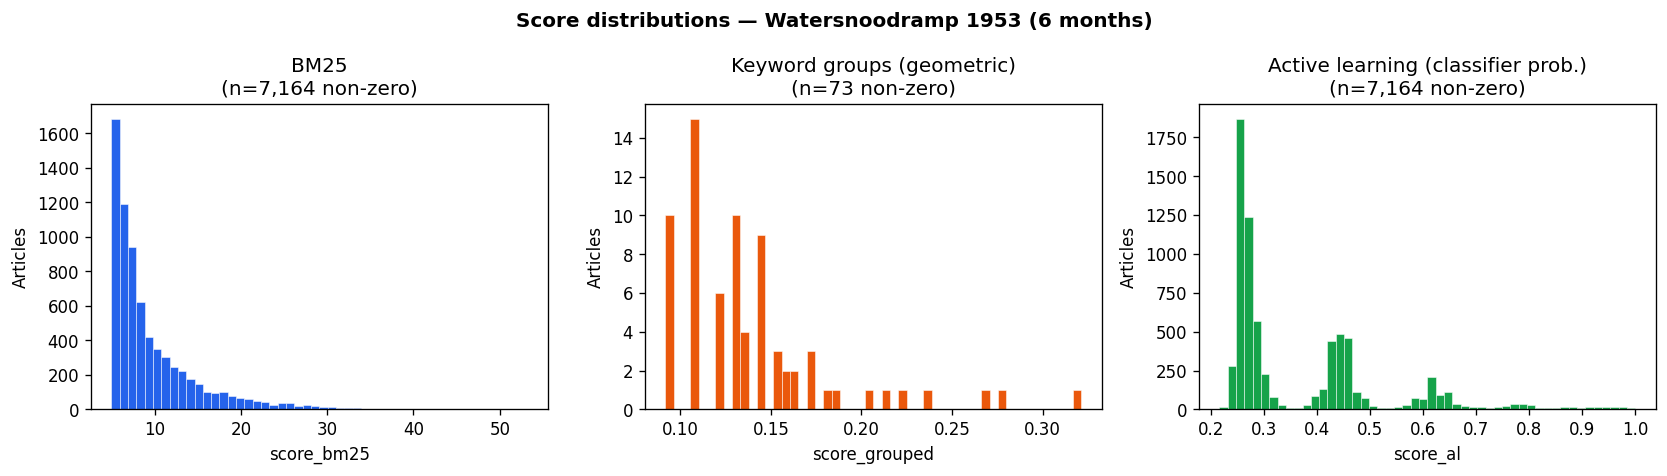

In [26]:
# Distribution of all three scores side by side
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

def _plot_hist(ax, data, col, color, title):
    nz = data.loc[data[col] > 0, col]
    ax.hist(nz, bins=50, color=color, edgecolor="white", linewidth=0.3)
    ax.set_title(f"{title}\n(n={len(nz):,} non-zero)")
    ax.set_xlabel(col)
    ax.set_ylabel("Articles")

_plot_hist(axes[0], df_al, "score_bm25",    "#2563eb", "BM25")
_plot_hist(axes[1], df_al, "score_grouped", "#ea580c", "Keyword groups (geometric)")
_plot_hist(axes[2], df_al, "score_al",      "#16a34a", "Active learning (classifier prob.)")

fig.suptitle(f"Score distributions — {event.full_name} ({WINDOW_MONTHS} months)",
             fontweight="bold")
plt.tight_layout()
plt.show()

---

## 5 — Three-way comparison and export

Each method draws a different boundary. This section puts all three side by side so you can choose a threshold for your research question.

In [27]:
!pip install scipy

In [28]:
# Merge all three score columns into one dataframe
df_compare = df_al[[DATE_COL, TEXT_COL, "score_bm25", "score_grouped", "score_al"]].copy()

# Rank each article by each method (1 = most relevant)
df_compare["rank_bm25"]    = df_compare["score_bm25"].rank(ascending=False, method="min")
df_compare["rank_grouped"] = df_compare["score_grouped"].rank(ascending=False, method="min")
df_compare["rank_al"]      = df_compare["score_al"].rank(ascending=False, method="min")

print("Rank correlation between methods:")
from scipy.stats import spearmanr

pairs = [
    ("BM25 vs grouped",  "score_bm25",    "score_grouped"),
    ("BM25 vs AL",       "score_bm25",    "score_al"),
    ("grouped vs AL",    "score_grouped", "score_al"),
]
for label, a, b in pairs:
    r, p = spearmanr(df_compare[a], df_compare[b])
    print(f"  {label:<22}: r={r:.3f}  (p={p:.2e})")

Rank correlation between methods:
  BM25 vs grouped       : r=0.112  (p=2.75e-21)
  BM25 vs AL            : r=0.137  (p=3.46e-31)
  grouped vs AL         : r=0.173  (p=2.03e-49)


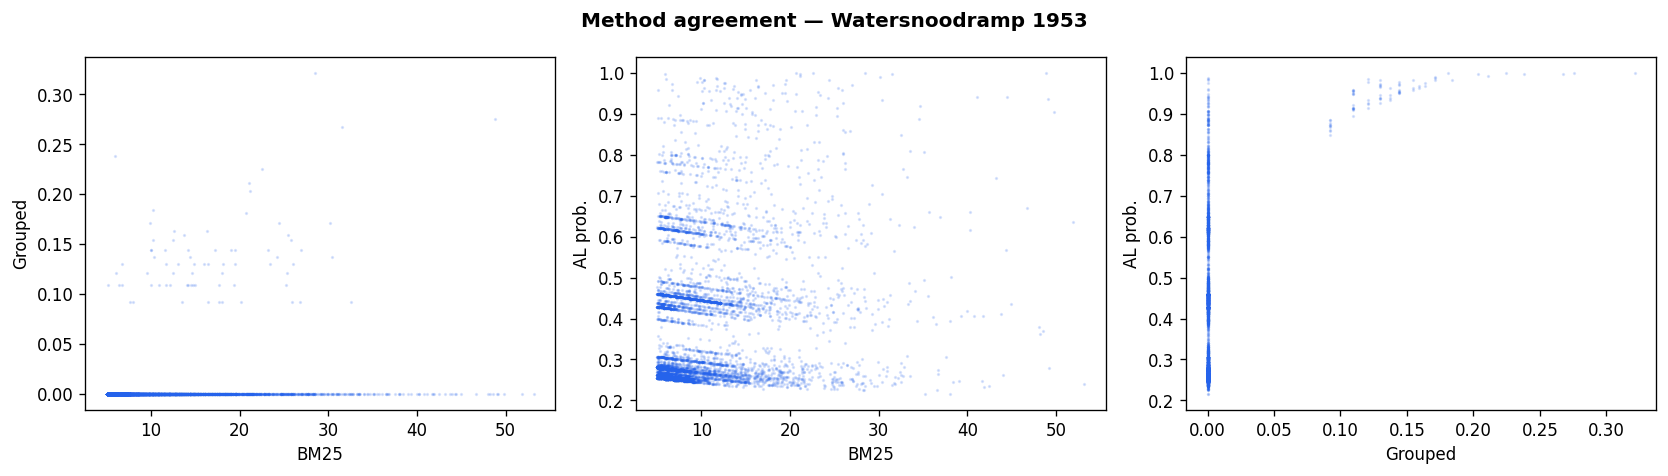

In [29]:
# Scatter matrix: how well do the methods agree?
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

def _scatter(ax, x_col, y_col, xlabel, ylabel):
    ax.scatter(df_compare[x_col], df_compare[y_col],
               s=1, alpha=0.15, color="#2563eb", rasterized=True)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

_scatter(axes[0], "score_bm25",    "score_grouped", "BM25",    "Grouped")
_scatter(axes[1], "score_bm25",    "score_al",      "BM25",    "AL prob.")
_scatter(axes[2], "score_grouped", "score_al",      "Grouped", "AL prob.")

fig.suptitle(f"Method agreement — {event.full_name}", fontweight="bold")
plt.tight_layout()
plt.show()

In [30]:
# How many articles pass different filter combinations?
print(f"{'Filter':<45} {'Articles':>10}")
print("-" * 58)

total = len(df_compare)
print(f"{'Total window':<45} {total:>10,}")

configs = [
    ("BM25 > 0",                     df_compare["score_bm25"] > 0),
    ("BM25 >= 1.0",                  df_compare["score_bm25"] >= 1.0),
    ("BM25 >= 5.0",                  df_compare["score_bm25"] >= 5.0),
    ("Grouped > 0 (all groups)",     df_compare["score_grouped"] > 0),
    ("Grouped >= 0.05",              df_compare["score_grouped"] >= 0.05),
    ("AL prob >= 0.5",               df_compare["score_al"] >= 0.5),
    ("AL prob >= 0.7",               df_compare["score_al"] >= 0.7),
    ("BM25 >= 1.0 AND grouped > 0",  (df_compare["score_bm25"] >= 1.0) &
                                     (df_compare["score_grouped"] > 0)),
    ("grouped > 0 AND AL >= 0.5",    (df_compare["score_grouped"] > 0) &
                                     (df_compare["score_al"] >= 0.5)),
]

for label, mask in configs:
    n = mask.sum()
    print(f"  {label:<43} {n:>10,}")

Filter                                          Articles
----------------------------------------------------------
Total window                                       7,164
  BM25 > 0                                         7,164
  BM25 >= 1.0                                      7,164
  BM25 >= 5.0                                      7,164
  Grouped > 0 (all groups)                            73
  Grouped >= 0.05                                     73
  AL prob >= 0.5                                   1,021
  AL prob >= 0.7                                     320
  BM25 >= 1.0 AND grouped > 0                         73
  grouped > 0 AND AL >= 0.5                           73


In [31]:
# ── Export ────────────────────────────────────────────────────────────────────
# Choose which filter to apply, then export.

# Option A: BM25 threshold
# final = al_sub.above(1.0, col="score_bm25")

# Option B: grouped score (all groups must be represented)
# final = al_sub.above(0.0, col="score_grouped")

# Option C: active-learning probability
# final = al_sub.above(0.5, col="score_al")

# Option D: grouped AND AL (recommended after several annotation rounds)
final = (
    al_sub
    .above(0.0, col="score_grouped")   # must cover all keyword groups
    .above(0.5, col="score_al")        # classifier must think it's relevant
)

print(f"Final selection: {len(final):,} articles")

# Sort by AL score (most confident first)
df_final = final.to_dataframe().sort_values("score_al", ascending=False)
display(
    df_final[[DATE_COL, "score_bm25", "score_grouped", "score_al"]].head(10).round(3)
)

Final selection: 1,021 articles


/tmp/ipykernel_1504/2416644437.py:25: UserWarning: obj.round has no effect with datetime, timedelta, or period dtypes. Use obj.dt.round(...) instead.
  df_final[[DATE_COL, "score_bm25", "score_grouped", "score_al"]].head(10).round(3)


,date,score_bm25,score_grouped,score_al
599,1953-02-02,28.474,0.321,1.000
697,1953-02-02,22.564,0.225,0.999
847,1953-02-02,20.673,0.181,0.999
698,1953-02-02,48.855,0.275,0.999
898,1953-02-14,5.922,0.238,0.998
756,1953-02-11,21.139,0.203,0.998
125,1953-02-02,31.536,0.267,0.998
503,1953-02-09,21.073,0.211,0.993
531,1953-02-17,30.181,0.171,0.990
622,1953-02-06,9.883,0.171,0.988


In [33]:
# Uncomment to save
df_final.to_csv(f"{EVENT_LABEL}_selection.csv", index=False)
print(f"Saved {len(df_final):,} articles to {EVENT_LABEL}_selection.csv")

print("Done. Uncomment the lines above to export to CSV.")

Saved 1,021 articles to watersnood_selection.csv
Done. Uncomment the lines above to export to CSV.
